## Text generation

The purpose of this project - construct a model, which will generate random verses based on the learned song lyrics.

As a base model, LSTM recurrent neural network was chosen.

Data sample - 20 song lyrics of the russian artist "Oxxxymiron" downloaded from Genius

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import lyricsgenius
from matplotlib import pyplot as plt
import json
import pickle

#For MSE models
import nltk
from nltk.util import bigrams, trigrams
from nltk.util import pad_sequence
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordTokenizer, TreebankWordDetokenizer
from nltk.lm import MLE


#For RNN model
import sys
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization,LSTM
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


## Importing songs

In [2]:
rapper = 'Oxxxymiron'
num_songs = 20

In [3]:
genius = lyricsgenius.Genius("jOoA2dCGT_F8pHJJmmd3HgXotfZlbpDr2Dwd9QTA2v122saEfQ3S-RDCu_xd76u7")

genius.skip_non_songs = True
genius.verbose = False
genius.remove_section_headers = True
genius.excluded_terms = ["(Remix)", "(Live)"]

The list of chosen songs:

In [4]:
artist = genius.search_artist(rapper, max_songs=num_songs)
print(artist.songs)

[('Город под подошвой (City Under the Sole)', 'Oxxxymiron'), ('«Где нас нет» (”On the Other Side”)', 'Oxxxymiron'), ('До зимы (Before Winter)', 'Oxxxymiron'), ('Неваляшка (Tumbler Toy)', 'Oxxxymiron'), ('В книге всё было по-другому (4 раунд 17ib) (The Book Had It Different)', 'Oxxxymiron'), ('Переплетено (Interlaced)', 'Oxxxymiron'), ('Тентакли (Tentacles)', 'Oxxxymiron'), ('Восточный Мордор (East Mordor)', 'Oxxxymiron'), ('Песенка Гремлина (Gremlin’s Song)', 'Oxxxymiron'), ('Признаки Жизни (Signs of Life)', 'Oxxxymiron'), ('Детектор лжи (Lie Detector)', 'Oxxxymiron'), ('Башня из слоновой кости (Ivory Tower)', 'Oxxxymiron'), ('Пролив Дрейка (Drake Passage)', 'Oxxxymiron'), ('Биполярочка (Bipolarochka)', 'Oxxxymiron'), ('Девочка Пиздец (Fucked Up Girl)', 'Oxxxymiron'), ('Последний звонок (Last Call)', 'Oxxxymiron'), ('Всего лишь писатель (Just a Writer)', 'Oxxxymiron'), ('Привет со дна  (Hello from the Bottom)', 'Oxxxymiron'), ('Не от мира сего (Not of This World)', 'Oxxxymiron'), ('Бол

In [5]:
lyrics = []
for i in range(len(artist.songs)):
    song = [artist.songs[i].lyrics]
    lyrics.append(song)
    
with open("oxxxymiron_lyrics.txt", "wb") as fp:
    pickle.dump(lyrics, fp)

In [6]:
#Unpickling our songs
with open("oxxxymiron_lyrics.txt", "rb") as fp:   
    lyrics = pickle.load(fp)

In [7]:
print(len(lyrics))

20


Example of the song lyrics:

In [8]:
print(lyrics[1])

['Sino hora sancta morta\nSino hora sancta morta\nSino hora sancta morta\n\nТам, где нас нет — горит невиданный рассвет\nГде нас нет — море и рубиновый закат\nГде нас нет — лес, как малахитовый браслет\nГде нас нет, на Лебединых островах\nГде нас нет, услышь меня и вытащи из омута\nВеди в мой вымышленный город, вымощенный золотом\nВо сне я вижу дали иноземные\nГде милосердие правит, где берега кисельные\n\nЭй, йоу\n«Ну-ка, слёзы вытер!\nТо ли дело их сын, сразу видно, что он лидер»\n«Слышишь, если спросят, то ты ничего не видел»\n«Ай, он весь в отца, из него ничего не выйдет»\n«Кто ж её не знает-то, всему двору сосала»\n«Это что такое? Руки! Я кому сказала?»\n«Всё разворовали, а бывал непобедимым»\n«Ваш ребёнок замкнут и не ладит с коллективом»\n«Марш в детский сад!» «Дружный класс». «Дважды два»\n«Раз на раз, баш на баш». «Чё, зассал? Не пацан?»\n«Тока глянь на себя, тут фингал, там синяк\nХулиган! Стыдоба! Как ты смел, кем ты стал?»\n«Мой-то? Да всё в облаках, как в детстве, витает»\

## Preparing data

In [9]:
clear_lyrics = lyrics
bad_chars = [';', ':', '!', '*', 'n', ',', '.', '"', "'", '(', ')', '?', '—', '\\', '[', ']', '»', '«']

for i in clear_lyrics:
    for char in bad_chars:
        clear_lyrics = str(clear_lyrics).replace(char,' ').lower()

In [10]:
#Make a function to tokenize & filter input data
def tokenize_words(input): 
    #Initiate the tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input)
    
    #Filter some words if they are in nltk stop list
    filtered = filter(lambda token: token not in stopwords.words('russian'), tokens)
    return " ".join(filtered)

In [11]:
#Preprocess our input data and make tokens
processed_inputs = tokenize_words(clear_lyrics)

In [12]:
print(processed_inputs[:100])

дон волга течёт котомку плечо боль груди тайничок открытый фомкой ключом сколько миль ещё перелет ко


In [13]:
#Since NN requires numbers, but not text characters, convert the characters in our input to numbers
chars = sorted(list(set(processed_inputs)))
char_to_num = dict((c, i) for i, c in enumerate(chars))

In [14]:
#For futher data preparation, calculate the length of our input and vocabulary
input_len = len(processed_inputs)
vocab_len = len(chars)

print ("Total number of characters:", input_len)
print ("Total vocab:", vocab_len)

Total number of characters: 39672
Total vocab: 72


In [15]:
#Define how long an individual sequence (one complete mapping of inputs characters as integers) to be
seq_length = 100

#Make empty lists to store our input and output data
x_data = []
y_data = []

In [16]:
#Loop through inputs - start at the beginning and go until we hit the final character we can create a sequence out of
for i in range(0, input_len - seq_length, 1):
    
    #Define input and output sequences
    #Input is the current character plus desired sequence length
    in_seq = processed_inputs[i:i + seq_length]

    #Output sequence is the initial character plus total sequence length
    out_seq = processed_inputs[i + seq_length]

    #Convert list of characters to integers and add the values to our lists
    x_data.append([char_to_num[char] for char in in_seq])
    y_data.append(char_to_num[out_seq])

In [17]:
#Total number of sequences
n_patterns = len(x_data)
print ("Total Patterns:", n_patterns)

Total Patterns: 39572


In [18]:
#Transform it to numpy array for our NN
X = np.reshape(x_data, (n_patterns, seq_length, 1))

#Make the numbers float for activation function being able to interpret them as probabilities
X = X/float(vocab_len)

In [19]:
#One-hot encode our data
y = np_utils.to_categorical(y_data)

## Constructing RNN LSTM model

In [20]:
#Construct stacked LSTM model
model = Sequential()

model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(y.shape[1], activation='softmax'))

In [21]:
#For our callback create a file with RNN weights
filename = "RNN_weights.hdf5"
filepath = "RNN_weights.hdf5"

In [22]:
#Set callback function to save the best weights
callbacks = [ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')]

In [23]:
#Compile RNN model on default adam optimizer and track categorical cross-entropy
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [24]:
history = model.fit(X, y, epochs=500, batch_size=256, callbacks=callbacks)

Epoch 1/500
39572/39572 [==============================] - 51s 1ms/step - loss: 3.7964

Epoch 00001: loss improved from inf to 3.79637, saving model to RNN_weights.hdf5
Epoch 2/500
39572/39572 [==============================] - 52s 1ms/step - loss: 3.1574

Epoch 00002: loss improved from 3.79637 to 3.15739, saving model to RNN_weights.hdf5
Epoch 3/500
39572/39572 [==============================] - 54s 1ms/step - loss: 3.0069

Epoch 00003: loss improved from 3.15739 to 3.00692, saving model to RNN_weights.hdf5
Epoch 4/500
39572/39572 [==============================] - 56s 1ms/step - loss: 2.9289

Epoch 00004: loss improved from 3.00692 to 2.92886, saving model to RNN_weights.hdf5
Epoch 5/500
39572/39572 [==============================] - 57s 1ms/step - loss: 2.8899

Epoch 00005: loss improved from 2.92886 to 2.88994, saving model to RNN_weights.hdf5
Epoch 6/500
39572/39572 [==============================] - 74s 2ms/step - loss: 2.8608

Epoch 00006: loss improved from 2.88994 to 2.86079,

In [25]:
with open('history', 'wb') as f:
     pickle.dump(history, f)

In [26]:
with open('history', 'rb') as f:
     history = pickle.load(f)

In [27]:
#Loading pre-trained weights
model.load_weights(filename)

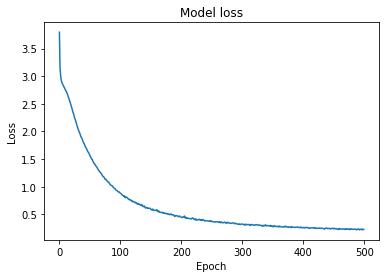

In [28]:
# Plot loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

On the graph, we can see the gradual decrease of cross-entropy loss, which is a good sign. There still exists a little downward slope, however it requires much more time to train and tuning in hyper parameters.

## Testing our model

In [29]:
#Define a dictionary that will convert the RNN output in numbers back to characters 
num_to_char = dict((i, c) for i, c in enumerate(chars))

In [115]:
#Provide our model with random seed character from which it will generate a sequence of characters
start = np.random.randint(0, len(x_data) - 1)
pattern = x_data[start]
print("Random Seed:")
print("\"", ''.join([num_to_char[value] for value in pattern]), "\"")

Random Seed:
"  дальше остановок видать пока нам ног сломит вражий костолом живём умрём удобрим гору собой став её  "


Example of the generated verse:

In [116]:
#Finally, generate rap
for i in range(120):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(vocab_len)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = num_to_char[index]
    seq_in = [num_to_char[value] for value in pattern]

    sys.stdout.write(result)

    pattern.append(index)
    pattern = pattern[1:len(pattern)]

углём недобром городе рабом бунтарём это круговорот природы червяков доест орёл червяки орла всё переплетено внедрим пол

As a result, our model generate new verses based on the learned vocabulary from 20 Oxxxymiron songs. Even though the model is not so good at constructing sentences yet as the human brain does, that is already a good prerequisite to further depvelopment. 